In [106]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV


import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns


In [116]:
#1) train,test data
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print(train.shape)
print(test.shape)

(15035, 21)
(6468, 20)


In [108]:
#1) train data에 대한 상관관계 확인 1
corrmat = train.corr()
top_corr_features = corrmat.index[abs(corrmat["price"])>=0.3]
top_corr_features

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'view', 'grade',
       'sqft_above', 'sqft_basement', 'lat', 'sqft_living15'],
      dtype='object')

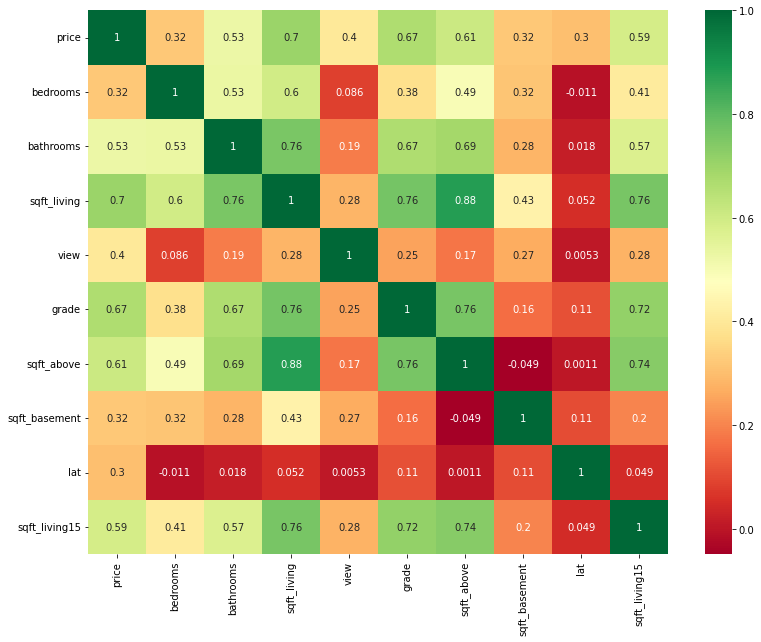

In [109]:
#1) train data에 대한 상관관계 확인 2
plt.figure(figsize=(13,10))
g = sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [117]:
#1-1)train y값 분리 , 정답 분리
y = train['price']
del train['price']

print(train.columns)


Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [118]:
#1-2) 분석을 위한 정리     train test 합체 > 왜 > 분석 통일성
train_len = len(train)  #train 갯수
data = pd.concat((train, test), axis=0)

print(len(data))

21503


<AxesSubplot:>

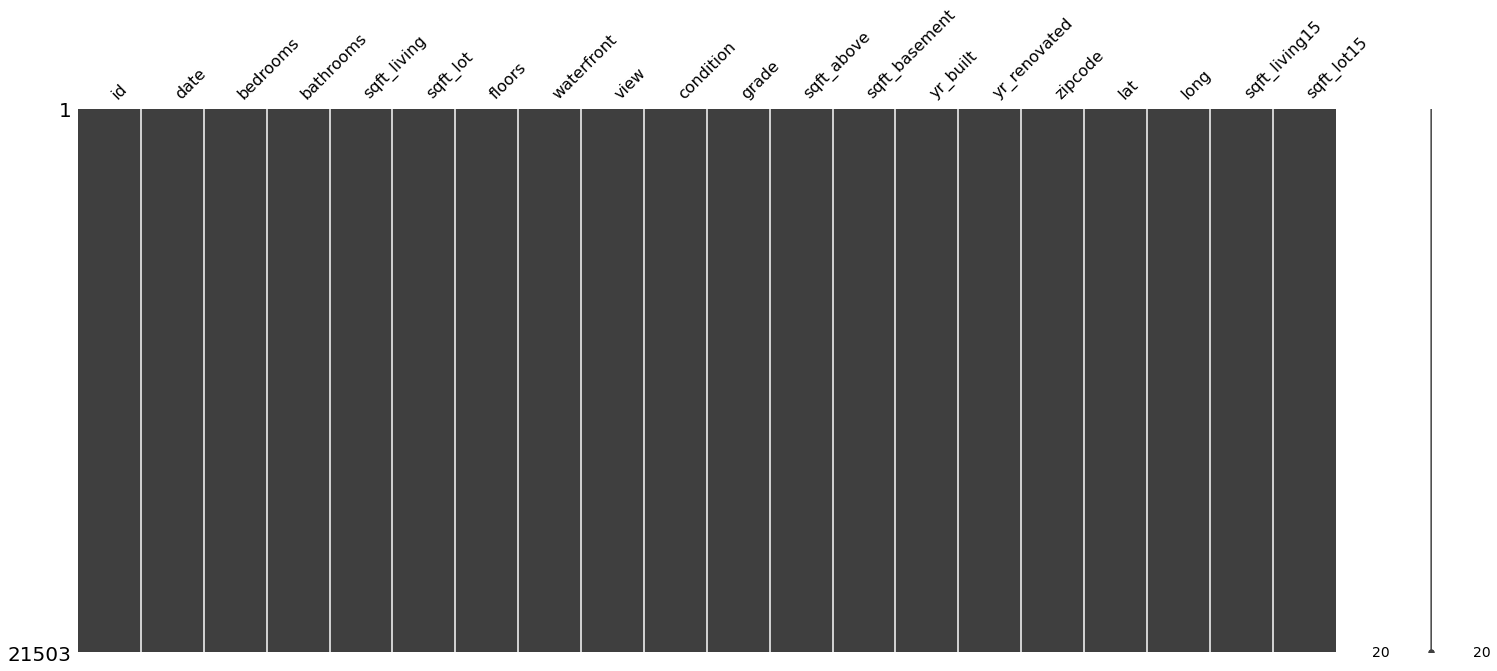

In [112]:
#2) 결측치 확인 data ( train+test)
msno.matrix(data)

In [119]:
# 2-1) sub_id 에 id 저장(test id), 2) data의 id삭제
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)
print(len(data))
print(len(sub_id))

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
21503
6468


In [122]:
# 2-2) data 의 date 정리
data['date'] = data['date'].apply(lambda x : str(x[:6]))
data['date'] = pd.to_numeric(data['date'])
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


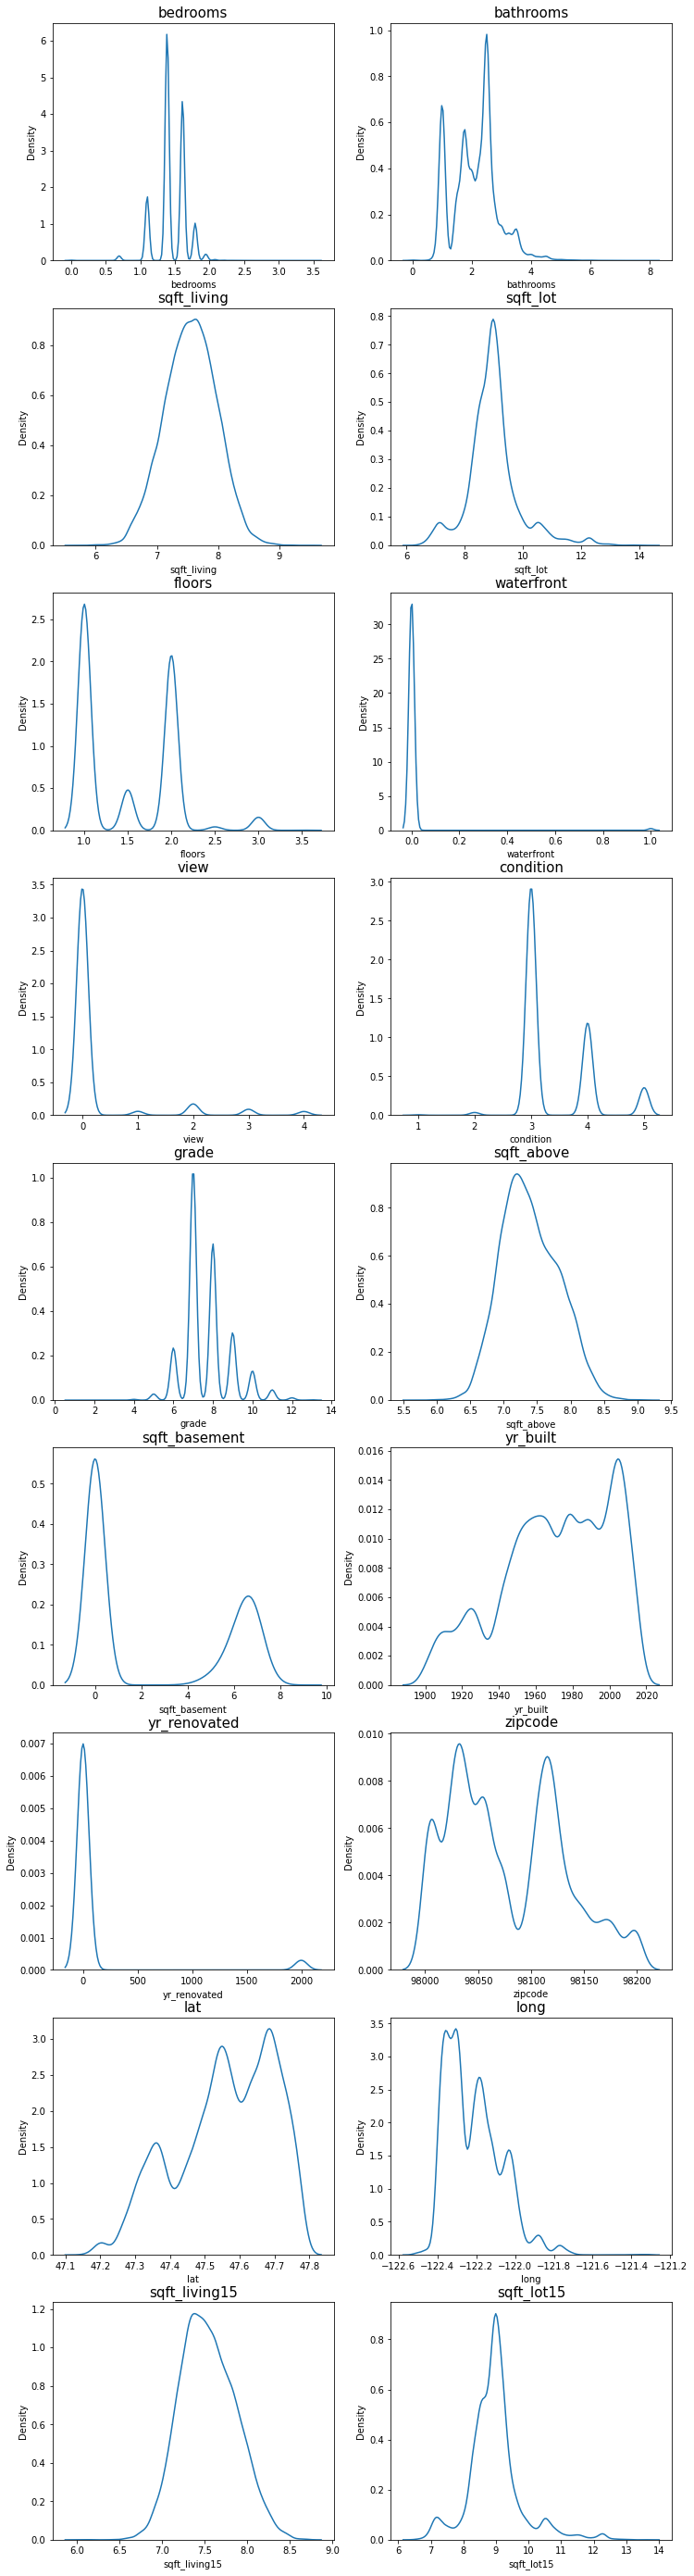

In [125]:
#2-3) data 본포 확인 
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break
#bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15

In [124]:
# 2-4) log변환  > 정규분포화 : bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15 
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

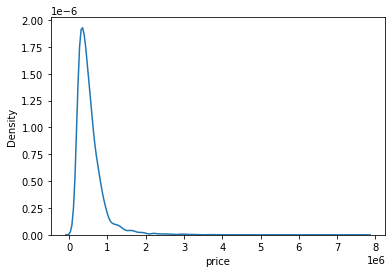

In [126]:
#2-5) price data 확인 1
sns.kdeplot(y)
plt.show()

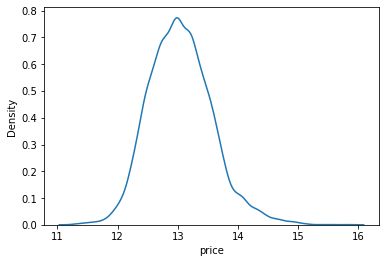

In [127]:
#2-6) price data 확인 2
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

In [128]:
#3) 분리 ... x, 
train_1 = data.iloc[:train_len, :]
test_1 = data.iloc[train_len:, :]

print(train_1.shape)
print(test_1.shape)

(15035, 19)
(6468, 19)


In [168]:
#4) Average Blending : 모델은 부스팅 계열인 gboost, xgboost, lightgbm 세 가지를 사용
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}, {'model':rdforest, 'name':'RandomForest'}]

#models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
#          {'model':lightgbm, 'name':'LightGBM'}]

In [130]:
#4-1) 모델의 성능 평가  1
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(train_1.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=train_1.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

In [131]:
#4-1) 모델의 성능 평가  2
get_cv_score(models)

Model: GradientBoosting, CV score:0.8609
Model: XGBoost, CV score:0.8860
Model: LightGBM, CV score:0.8819


In [132]:
#5) blenfing models  1
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)


In [158]:
#5) blenfing models  2
y_pred = AveragingBlending(models, train_1, y, test_1)
print(len(y_pred))
y_pred

6468


array([ 506625.66235339,  493617.23594325, 1288551.20851399, ...,
        468702.33507118,  334024.4205586 ,  427560.65730986])

In [134]:
#6) 최적 pameter 찾기
from sklearn.model_selection import GridSearchCV

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)
    
    #수행
    grid_model.fit(train, y)
    
    #원하는 값 분리  ... 찾고자 하는 parameter
    params = grid_model.cv_results_['params']
    # model 에 의해서 산출된 score   , grid_model.cv_results_ 결과 tablr???
    score = grid_model.cv_results_['mean_test_score']
    
    # parameter,score를 data frame으로 변화  .. 원하는 data 
    results = pd.DataFrame(params)
    results['score'] = score
    
    # rmse 생성
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    # 위의 표를 `RMSLE`가 낮은 순서대로 정렬해주세요.
    results = results.sort_values(['RMSLE'])
    
    return results


In [135]:
train_1.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,0,98178,47.5112,-122.257,7.201171,8.639588
1,201502,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,0,98028,47.7379,-122.233,7.908755,8.995041
2,201502,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,0,98074,47.6168,-122.045,7.496097,8.923191
3,201406,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,0,98003,47.3097,-122.327,7.713785,8.827615
4,201501,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,0,98198,47.4095,-122.315,7.409136,9.181118


In [173]:
# 6-1)최적의 paramenter 찾기 , LGBMRegressor
param_grid = {
    'n_estimators': [10, 100],
    'max_features' : [4, 15],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train_1, y, param_grid, verbose=2, n_jobs=5)
#max_depth=10, n_estimators=100, learning_rate=0.1, max_features=4

Fitting 5 folds for each of 8 candidates, totalling 40 fits


,max_depth,max_features,n_estimators,score,RMSLE
5,10,4,100,-1.636420e+10,127922.615898
7,10,15,100,-1.636420e+10,127922.615898
1,1,4,100,-3.851269e+10,196246.498903
3,1,15,100,-3.851269e+10,196246.498903
4,10,4,10,-4.182180e+10,204503.786524
6,10,15,10,-4.182180e+10,204503.786524
0,1,4,10,-8.871050e+10,297843.074509
2,1,15,10,-8.871050e+10,297843.074509


In [174]:
# 6-2)최적의 paramenter 찾기 , GradientBoostingRegressor
param_grid = {
    'n_estimators': [10, 100],
    'max_features' : [6, 15],
    'max_depth': [1, 10],
}

model = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model, train_1, y, param_grid, verbose=2, n_jobs=5)
#max_depth=10, n_estimators=100, max_features=15


Fitting 5 folds for each of 8 candidates, totalling 40 fits


,max_depth,max_features,n_estimators,score,RMSLE
7,10,15,100,-1.566759e+10,125170.254034
5,10,6,100,-1.737680e+10,131821.103125
6,10,15,10,-3.435852e+10,185360.517359
3,1,15,100,-3.733145e+10,193213.487235
4,10,6,10,-3.767846e+10,194109.401304
1,1,6,100,-3.844367e+10,196070.571785
2,1,15,10,-8.915127e+10,298582.091547
0,1,6,10,-9.196636e+10,303259.564200


In [175]:
## 6-3) 최적의 paramenter 찾기 , RandomForestRegressor
param_grid = {
    'n_estimators': [10, 100],
    'max_features' : [4, 15],
    'max_depth': [1, 10],
}

model = RandomForestRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
#max_depth=10, n_estimators=100, max_features=15

Fitting 5 folds for each of 8 candidates, totalling 40 fits


,max_depth,max_features,n_estimators,score,RMSLE
7,10,15,100,-1.926369e+10,138793.701264
6,10,15,10,-2.189278e+10,147962.103472
5,10,4,100,-2.227057e+10,149233.279306
4,10,4,10,-2.366255e+10,153826.366876
3,1,15,100,-8.324179e+10,288516.529135
2,1,15,10,-8.555947e+10,292505.498710
0,1,4,10,-8.634401e+10,293843.518386
1,1,4,100,-8.917291e+10,298618.328825


In [144]:
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

def save_submission(prediction, model_name, rmsle=None):
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [239]:
#  적용 할 모델 
random_state=2020 # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 
#max_depth=10, n_estimators = 100, 
gboost = GradientBoostingRegressor(max_depth=6, n_estimators=100, max_features=15,random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor( max_depth=6, n_estimators=100, random_state=random_state)
rdforest = RandomForestRegressor(max_depth=6,n_estimators=100, max_features=15, random_state=random_state)

#n_estimators=30, max_features=6
#models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
#          {'model':lightgbm, 'name':'LightGBM'}]

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}, {'model':rdforest, 'name':'RandomForest'}]

In [240]:
prediction = AveragingBlending(models, train_1, y, test_1)
print(len(prediction))
prediction


6468


array([ 501741.17689877,  441298.32577883, 1374977.36863779, ...,
        450936.85428468,  354659.59794624,  437944.69720945])

In [241]:
save_submission(prediction, 'blend', rmsle='0.0188')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_blend_RMSLE_0.0188.csv saved!
